## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))
# train['anatom_enc'] = enc.fit_transform(train['anatom_site_general_challenge'].astype('str'))
# test['anatom_enc'] = enc.transform(test['anatom_site_general_challenge'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# train = pd.concat([train, pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom_enc')], axis=1)
# test = pd.concat([test, pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom_enc')], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())
# Age
# train['anatom_mean'] = train['anatom_site_general_challenge'].map(train.groupby(['anatom_site_general_challenge'])['target'].mean())
# test['anatom_mean'] = test['anatom_site_general_challenge'].map(train.groupby(['anatom_site_general_challenge'])['target'].mean())


# External features
train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
           'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
           'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
for ft in ext_fts:
    train[ft] = train_img_ft[ft]
    test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,...,1.835102,1.428571,1.176471,0.368451,24.984602,1.309416,0.272855,0.098885,52.594848,0.428426
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,...,1.301577,1.666667,1.095238,0.391409,25.587810,1.240345,0.317342,0.125999,57.991760,0.430091
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,...,1.475337,1.531477,0.581197,0.209879,14.387222,1.272196,0.410767,0.138850,56.623874,0.423386
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,...,2.772424,1.000000,2.000000,0.643102,47.842749,1.504529,0.830075,0.271822,46.900691,0.425073
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,...,1.358362,1.479167,1.100000,0.361749,23.899347,1.310327,0.357306,0.125601,57.289260,0.428426


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean,V1,V2,V3,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231,0.1024,14,13671.8750,...,1.899913,1.250000,0.949153,0.326860,24.660825,1.384345,0.830075,0.231371,51.690459,0.426753
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231,0.1024,9,8789.0625,...,1.482239,1.363636,0.615385,0.184831,13.580182,1.311702,0.556334,0.186888,54.321052,0.438307
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766,0.1024,5,4882.8125,...,1.354060,1.666667,1.250000,0.480622,29.233718,1.236259,0.409636,0.171080,57.767034,0.425073
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766,0.1024,4,3906.2500,...,1.335321,1.734166,1.333333,0.626502,36.844012,1.253537,0.358360,0.153529,57.288517,0.436678
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766,0.1024,3,2929.6875,...,1.232224,2.222222,1.226930,0.565741,30.575912,1.260437,0.384288,0.174129,59.508983,0.425073


# Model

In [6]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
features += ext_fts
print(features)

params = {'n_estimators': 750,
          'min_child_weight': 0.81,
          'learning_rate': 0.025,
          'max_depth': 2,
          'subsample': 0.80,
          'colsample_bytree': 0.42,
          'gamma': 0.10,
          'random_state': SEED,
          'n_jobs': -1}

['age_approx', 'sex_mean', 'sex_enc', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']


# Training

In [7]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'validation' if x['tfrecord'] in idxT else 'train', axis=1)
    
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], 
              eval_metric='auc', early_stopping_rounds=10, verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Feature importance

Fold: 1


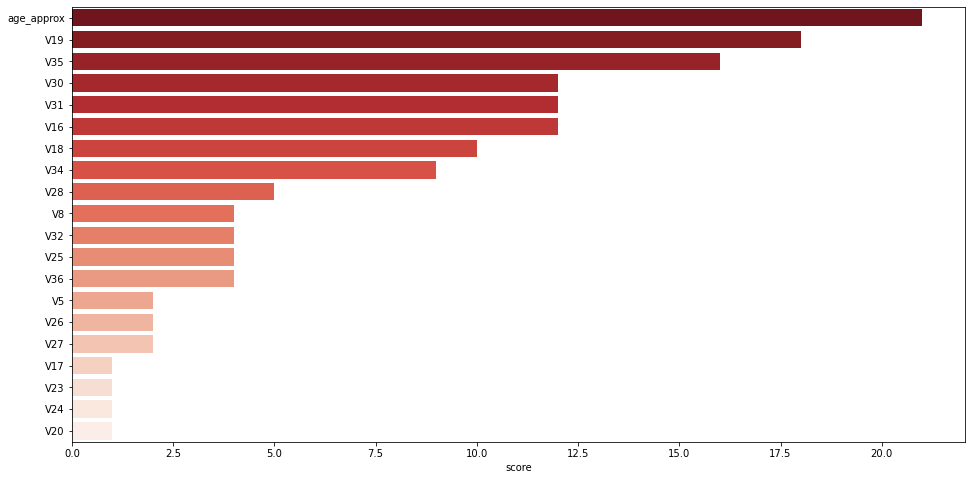

Fold: 2


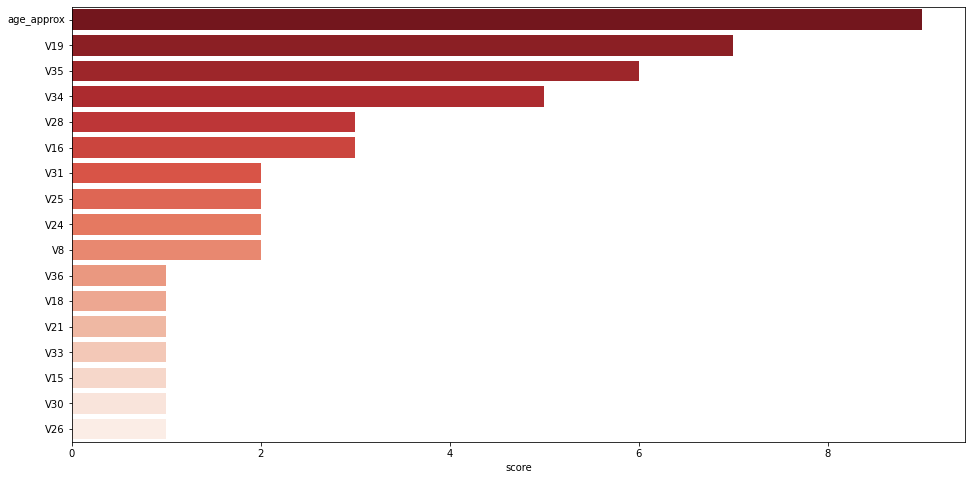

Fold: 3


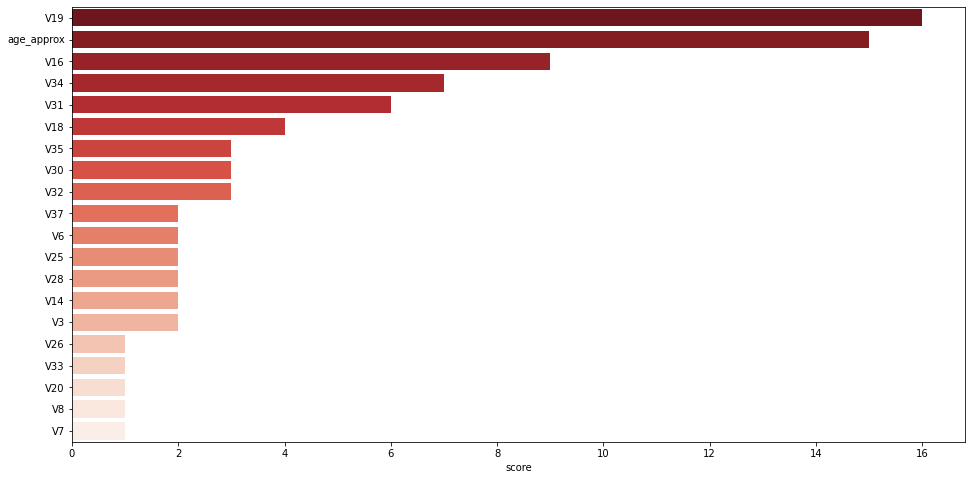

Fold: 4


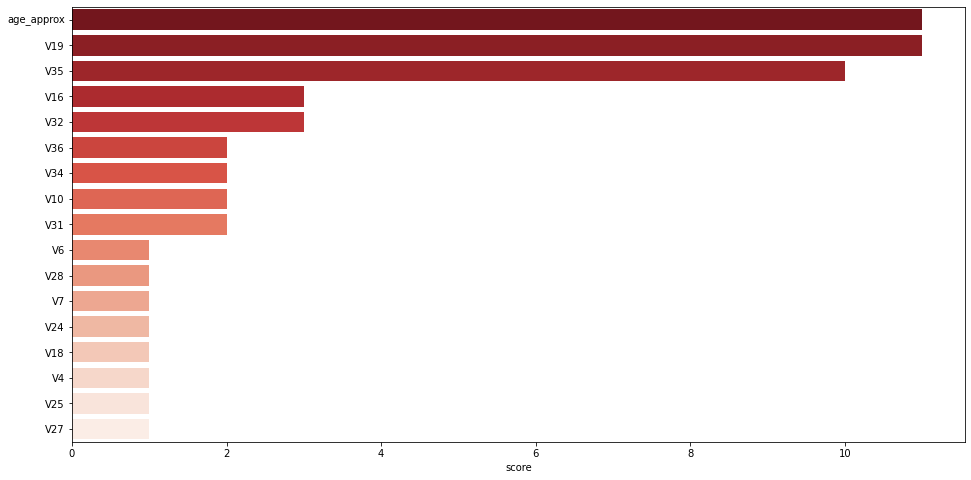

Fold: 5


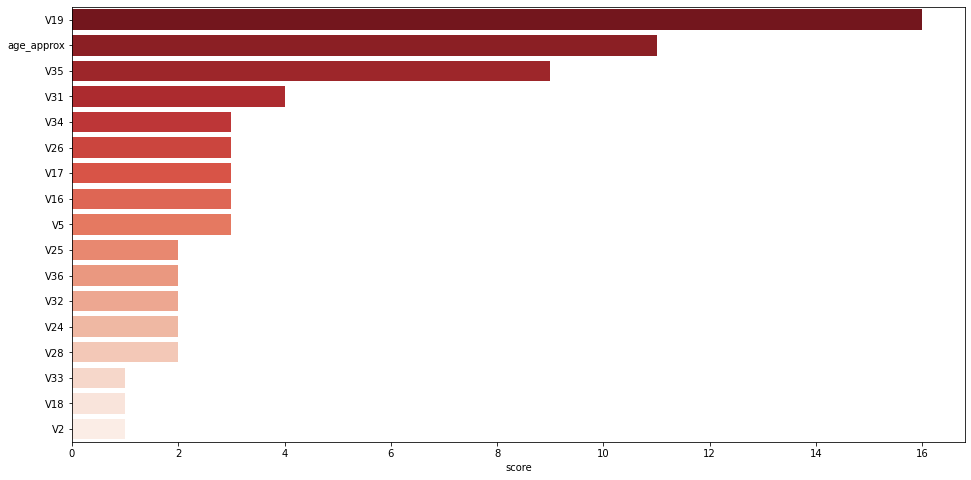

In [8]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [9]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.746723,0.754998,-0.008275,0.744911,0.766993,0.711145,0.729110,0.747210,0.762634,0.768865,0.750554,0.761485,0.765700
Accuracy,0.982904,0.982228,0.000676,0.982927,0.982222,0.982922,0.982223,0.982966,0.982211,0.982875,0.982236,0.982830,0.982247
Precision,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Support,119.200000,464.800000,-345.600000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,120.000000,464.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.746723,0.754998,-0.008275,0.744911,0.766993,0.711145,0.729110,0.747210,0.762634,0.768865,0.750554,0.761485,0.765700
male,0.737127,0.746286,-0.009160,0.719419,0.756250,0.735916,0.727949,0.699645,0.760442,0.761557,0.743653,0.769096,0.743138
female,0.746006,0.759840,-0.013834,0.771129,0.772143,0.668698,0.724242,0.781561,0.759749,0.771712,0.754043,0.736932,0.789024
head/neck,0.760748,0.718467,0.042281,0.756765,0.721084,0.822426,0.666807,0.667964,0.761999,0.811859,0.693875,0.744727,0.748569
upper extremity,0.731807,0.757585,-0.025778,0.717516,0.775297,0.726836,0.722753,0.740618,0.763720,0.721351,0.766860,0.752712,0.759292
lower extremity,0.678233,0.698523,-0.020290,0.703367,0.701405,0.608972,0.700955,0.678646,0.700455,0.701348,0.688576,0.698834,0.701226
torso,0.788456,0.794276,-0.005819,0.788238,0.806691,0.719543,0.771953,0.817522,0.793981,0.805979,0.792141,0.811000,0.806612
0 <= age < 26,0.723899,0.765585,-0.041686,0.684407,0.794073,0.478923,0.763757,0.900794,0.776482,0.853771,0.705036,0.701601,0.788575
26 <= age < 40,0.762022,0.726827,0.035195,0.738874,0.744815,0.890909,0.712179,0.721259,0.718315,0.688666,0.737292,0.770404,0.721536


# Adversarial Validation

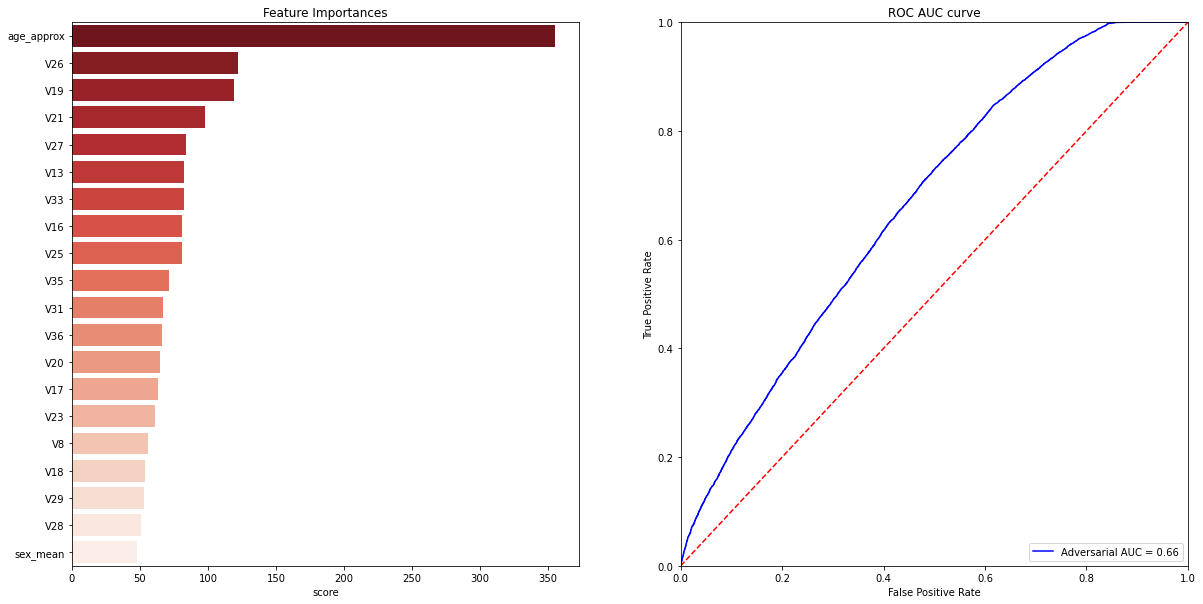

In [10]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [11]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.344915,0.206400,0.431520,0.309792,0.411580,0.365280
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.343920,0.202677,0.432068,0.308579,0.411738,0.364536
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.349462,0.211404,0.434064,0.316429,0.415182,0.370233
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
7,ISIC_0075663,female,35.0,torso,unknown,0,0.346739,0.206045,0.432864,0.312259,0.413728,0.368798
8,ISIC_0075914,male,30.0,torso,unknown,0,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.343864,0.202400,0.432068,0.308579,0.411738,0.364536
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.348989,0.207078,0.432864,0.312806,0.425434,0.366761
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.343962,0.202509,0.431520,0.309814,0.410926,0.365042
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.342510,0.200354,0.431520,0.306328,0.410482,0.363865
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.350611,0.216774,0.433973,0.316742,0.415053,0.370514
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.344195,0.204226,0.432068,0.308925,0.411738,0.364019
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.363246,0.224128,0.434521,0.347409,0.417092,0.393080
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.356018,0.225215,0.437596,0.320204,0.415835,0.381241
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Visualize test predictions

In [12]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.344812,0.204803,0.431520,0.311236,0.410926,0.365575
1,ISIC_0052349,male,40.0,lower extremity,0.344112,0.203302,0.432068,0.308579,0.411738,0.364871
2,ISIC_0058510,female,55.0,torso,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
3,ISIC_0073313,female,50.0,torso,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
4,ISIC_0073502,female,45.0,lower extremity,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
5,ISIC_0074618,male,50.0,lower extremity,0.344669,0.204855,0.432068,0.309402,0.412998,0.364019
6,ISIC_0076801,male,45.0,upper extremity,0.351103,0.216002,0.435651,0.316463,0.415043,0.372357
7,ISIC_0077586,male,50.0,lower extremity,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
8,ISIC_0082004,female,45.0,torso,0.341942,0.198472,0.431520,0.306074,0.410482,0.363161
9,ISIC_0082785,male,65.0,lower extremity,0.344608,0.204317,0.431520,0.311236,0.410926,0.365042


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Test set predictions

In [13]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)

,image_name,target
0,ISIC_0052060,0.344812
1,ISIC_0052349,0.344112
2,ISIC_0058510,0.341942
3,ISIC_0073313,0.341942
4,ISIC_0073502,0.341942
5,ISIC_0074618,0.344669
6,ISIC_0076801,0.351103
7,ISIC_0077586,0.341942
8,ISIC_0082004,0.341942
9,ISIC_0082785,0.344608


,target
count,10982.000000
mean,0.344106
std,0.003560
min,0.341942
25%,0.341942
50%,0.342158
75%,0.344608
max,0.389626
